# I. Introduction

**Name**  : Dafa Wiratama
**Batch** : Data Science - Batch 09

In this project, I will be using the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package).

This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No?
This column is Yes if the rain for that day was 1mm or more.

> ## Context
> Predict next-day rain by training classification models on the target variable RainTomorrow.
> Find the best model for predicting RainTomorrow using the following metrics:
> - Accuracy
> - F1-score

> ## Content
> This dataset contains about 10 years of daily weather observations from many locations across Australia.
> RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

> ## Source & Acknowledgements
> Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data.
> An example of latest weather observations in Canberra: http://www.bom.gov.au/climate/dwo/IDCJDW2801.latest.shtml
>
>> Definitions adapted from [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)
>> Data source: [http://www.bom.gov.au/climate/dwo/](http://www.bom.gov.au/climate/dwo/) and [http://www.bom.gov.au/climate/data](http://www.bom.gov.au/climate/data).
>
> Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

# II.  Import Libraries

In [1]:
from sklearn.experimental import enable_iterative_imputer
import re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn import neural_network
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, pipeline, compose
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# III. Data Loading
Let's load the dataset into our dataframe.

In [2]:
dataset = pd.read_csv('weatherAUS.csv')

> ## Columns Type
> from the table below we can see many of column are categorical, numeric and datetime and high degree of missing values.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

> ## Columns Description
> From fast reading the table we can see that many column have high degree of outliers.

In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


> ## Column Renaming
> We will rename the columns to make it easier to understand and use.
> in this case i will use the help of Regex to rename the columns from title case to snake case.

In [5]:
def title_to_lowercase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [6]:
dataset.columns = [title_to_lowercase(col) for col in dataset.columns]

In [7]:
dataset

,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir9am,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rain_today,rain_tomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


> ## Row Indexing
> lest see if the date is unique or not.

> from the code below we can see that the date is not unique because we have the data from many city at same date so i will not use this column as index. but i will cast the date column into datetime format.

In [8]:
dataset['date'].is_unique

False

In [9]:
dataset['date'] = pd.to_datetime(dataset['date'])

# IV. Exploratory Data Analysis

In [10]:
dataset.head(8)

,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir9am,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rain_today,rain_tomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No


> ## Wind Direction
> Let's start from the wind direction column.
> this column was based on the direction of the wind but in discrete value [N, NNE, NE, etc...] and speed of the wind in unknown unit.

> **is it possible to convert this column into a numeric value or at least it representation?**
> From my understanding this column can be transformed into a numeric value (0-360). but it will raise some problem ahead can you guest it?
>
> Yes the direction 360 degree is the same as 0 degree. so we need some way to represent the direction of the wind that doesn't have this problem.
> in my experience i will transform it to the frequency of the wind direction or just fitting the radian of the wind direction. as we recall the value of sin is always connected or continuous. with a known boundary (-1, 1)


In [11]:
sorted_wind_cardinal = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW',
                        'NNW']

wind_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

> Let's start with the visualisation

> **can you see it now?**
> the graph before and after transformation is still represent the same direction. only on is linear step and discontinuous between 0 - 360 degree. and one was non linear but preserve the continuity.

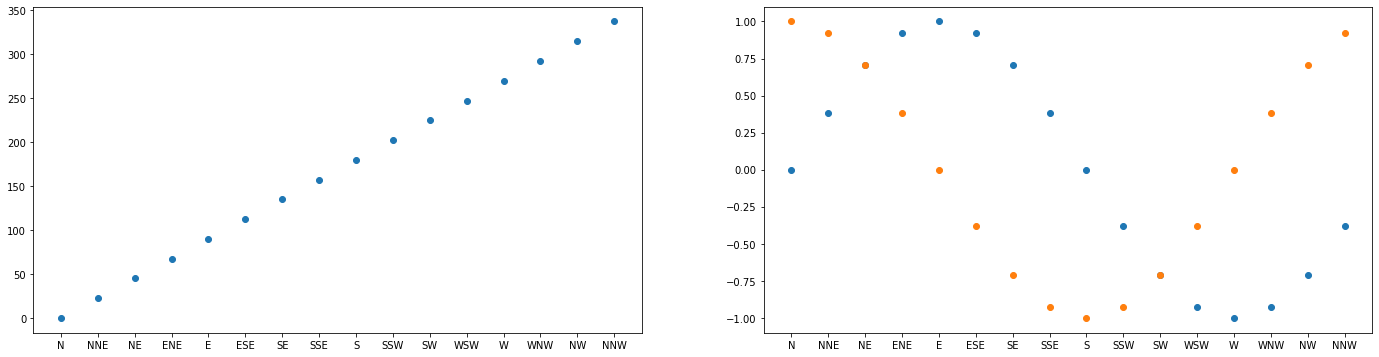

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8 * 3, 6))

ax[0].plot(wind_map.keys(), wind_map.values(), 'o')

normalize_feature = (np.array([x for x in wind_map.values()]) / 180) * np.pi
sin_feature = np.sin(normalize_feature)
cos_feature = np.cos(normalize_feature)

ax[1].plot(wind_map.keys(), sin_feature, 'o')
ax[1].plot(wind_map.keys(), cos_feature, 'o');

> ## Utility Functions
> I will use the following function to transform the wind direction into a numeric value.
> and I will not try to explain it in this project

> **Why?**
> Because i don't want to overcomplicate the project now by explaining to much about the technique.

In [13]:
class MapTransformer(TransformerMixin):
    def __init__(self, dict_map):
        self.dict_map = dict_map

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x.replace(self.dict_map)

In [14]:
class SinCosTransformer(TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        _x = []
        for col in x.columns:
            _x.append(np.sin(x[col] * 2 * np.pi))
            _x.append(np.cos(x[col] * 2 * np.pi))
        return np.array(_x).T

In [15]:
class WindVectorTransformer(TransformerMixin):
    fitted = False

    def __init__(self, encoder):
        self.encoder = encoder
        self.scaler = preprocessing.StandardScaler()

    def fit(self, x, y=None):
        _sample = self.transform(x)
        self.scaler.fit(np.reshape(_sample, (-1, 1)))
        self.fitted = True
        return self

    def transform(self, x):
        direction, speed = x.columns
        direction = x[direction].replace(self.encoder) / 360

        _sin = x[speed] * np.sin(direction * 2 * np.pi)
        _cos = x[speed] * np.cos(direction * 2 * np.pi)

        if not self.fitted:
            self.scaler.fit(np.reshape(_sin.values, (-1, 1)))
            self.scaler.fit(np.reshape(_sin.values, (-1, 1)))
        else:
            _sin = self.scaler.transform(np.reshape(_sin.values, (-1, 1)))[:, 0]
            _cos = self.scaler.transform(np.reshape(_cos.values, (-1, 1)))[:, 0]

        return np.array([_sin, _cos]).T

    def get_params(self, deep=True):
        return {'encoder': self.encoder}

    def set_params(self, **params):
        self.encoder = params['encoder']
        return self

> ## Wind Direction and Speed Distribution
> to better understand the distribution i have plotted the original data and the transformed data. and from the original data all the feature have overlying distribution and that not good for the model.

> **Can the transformation help to improve the distribution?**
> Let's see.

<AxesSubplot:xlabel='wind_gust_dir', ylabel='wind_gust_speed'>

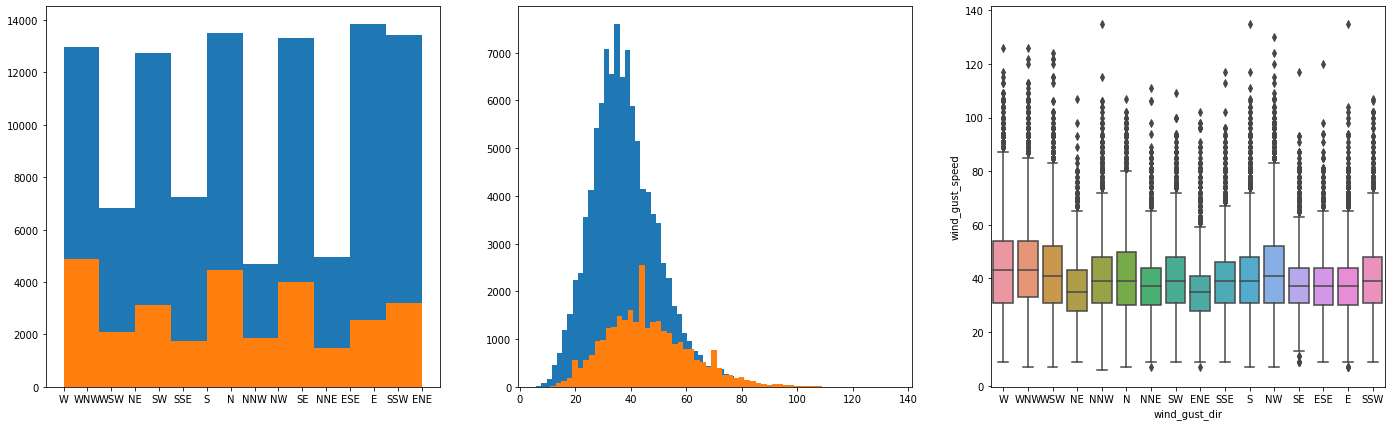

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 7))
ax[0].hist(dataset[dataset['rain_tomorrow'] == 'No']['wind_gust_dir'].dropna())
ax[0].hist(dataset[dataset['rain_tomorrow'] == 'Yes']['wind_gust_dir'].dropna())
ax[1].hist(dataset[dataset['rain_tomorrow'] == 'No']['wind_gust_speed'].dropna(), bins=64)
ax[1].hist(dataset[dataset['rain_tomorrow'] == 'Yes']['wind_gust_speed'].dropna(), bins=64)

_df = dataset[['wind_gust_dir', 'wind_gust_speed']].dropna()

sns.boxplot(x='wind_gust_dir', y='wind_gust_speed', data=_df, ax=ax[2])

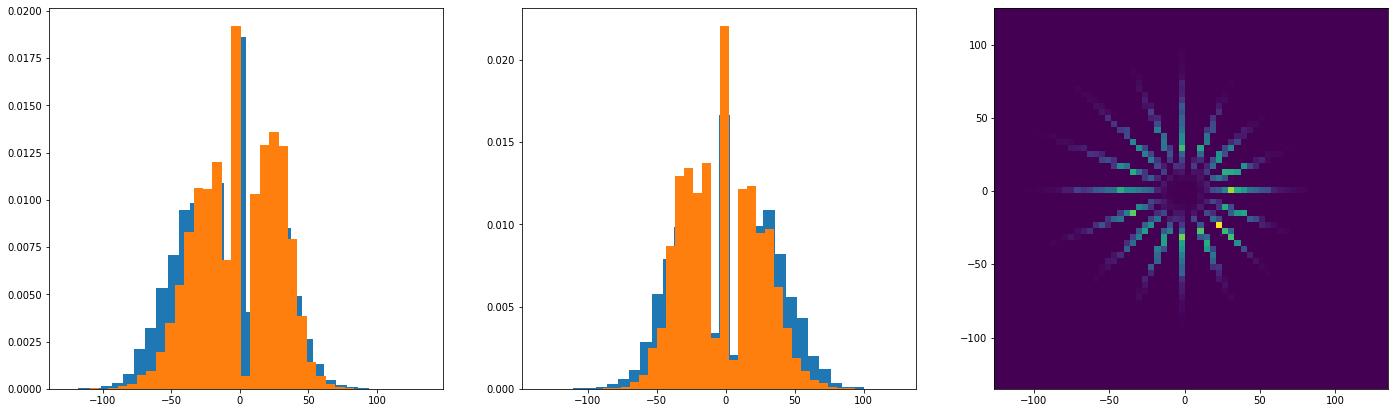

In [17]:
_ds = dataset[['wind_gust_dir', 'wind_gust_speed', 'rain_tomorrow']].dropna()

result = WindVectorTransformer(encoder=wind_map)
a = result.transform(
    dataset[['wind_gust_dir', 'wind_gust_speed', 'rain_tomorrow']].dropna()[['wind_gust_dir', 'wind_gust_speed']])
result.fit(dataset[['wind_gust_dir', 'wind_gust_speed']])

fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 7))
ax[0].hist(a[_ds['rain_tomorrow'] == 'Yes'][:, 0], bins=32, density=True, label='Rain')
ax[0].hist(a[_ds['rain_tomorrow'] == 'No'][:, 0], bins=32, density=True, label='Not Rain')
ax[1].hist(a[_ds['rain_tomorrow'] == 'Yes'][:, 1], bins=32, density=True, label='Rain')
ax[1].hist(a[_ds['rain_tomorrow'] == 'No'][:, 1], bins=32, density=True, label='Not Rain')
ax[2].hist2d(a[:, 0], a[:, 1], bins=64);

> From the Transformed data plot above we can see that the distribution is much better. that the distribution among 2 class was separated little. at leas it was better that nothing

> ## Temporal Features (Date)
> some of you may thinking what is Temporal Features. it other word it just mean a feature that is related to the time or change in time.

>> **so why it is so important in this case?**
>> it was important because we lean in Elementary School that we have `Season` that will affect or effected by weather. so we need a way to distinguish the season. we as human may describe season by its month but the statistical model will not understand that.
>
>> **so what is the best way to do that?**
>> first we can try to create Cardinality between them, but it will leave us with discountinuity in month 12 and 1 same like wind direction and speed. so we can try to create a feature that will represent the season in continuous way but keeping the distance between cycle.

In [18]:
class TemporalEncoder(TransformerMixin):
    def __init__(self, freq):
        if freq == 'Y':
            self.freq = 365 * 24 * 60 * 60
        elif freq == 'Q':
            self.freq = 365 * 24 * 60 * 60 / 4
        else:
            raise ValueError('freq must be either D or Y')

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        _x = x.copy()
        for col in x.columns:
            _x[col] = np.array(x[col].view('int64') * 1e-9, dtype=np.int64)
        return (_x % self.freq) / self.freq

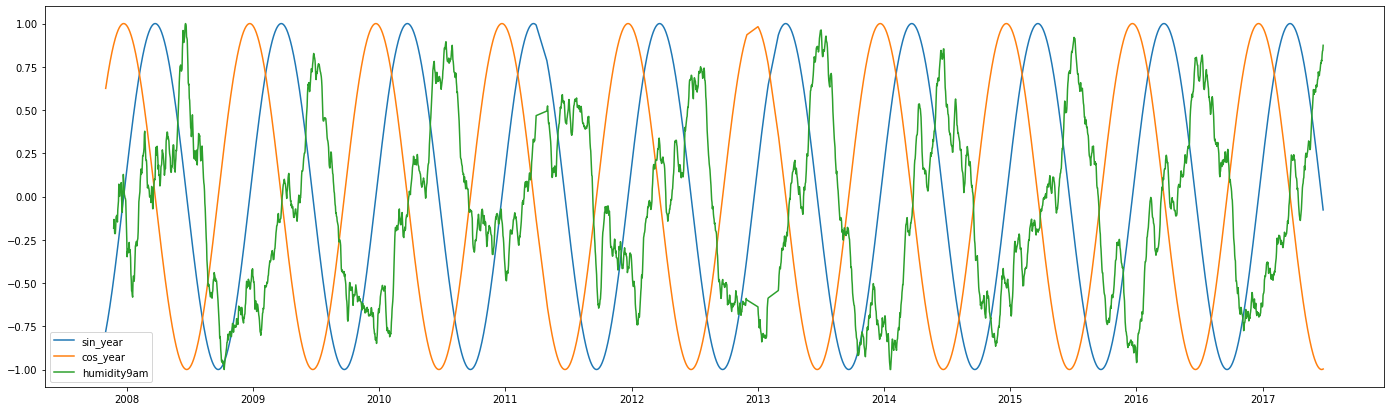

In [19]:
create_temporal_pipeline = lambda x: pipeline.Pipeline([
    ('temporal_encoder', TemporalEncoder(x)),
    ('sin_cos', SinCosTransformer())
])

plt.figure(figsize=(8 * 3, 7))
dd = dataset.copy().groupby('date').median().reset_index()
c = create_temporal_pipeline('Y').transform(dd[['date']])
plt.plot(dd.date, c)

col = dd['humidity9am'].rolling(window=24).mean()
normed_col = ((col - col.min()) / ((col.max() - col.min()) / 2)) - 1
plt.plot(dd.date, normed_col)
plt.legend(['sin_year', 'cos_year', 'humidity9am']);

> From the visualisation above we can see that our new temporal feature was good non-linear indicator for other column as we can see there are clear repetition in the data. in between year like humidity above.


> ## Other Features
> **so what other features can we use to improve the model?**
> There are 2 ways this can end up we do quick analysis, and then we can try to find the best way to improve the model.
> or just drop the features that are not important.
>
> let's put our best effort in this case. by creating the difference probability between the two class in the feature first.

>> ### Feature and Target Correlation
>> from the correlation plot above we can see that the target is highly correlated with what feature. and we will try to better understand the correlation. one by one feature

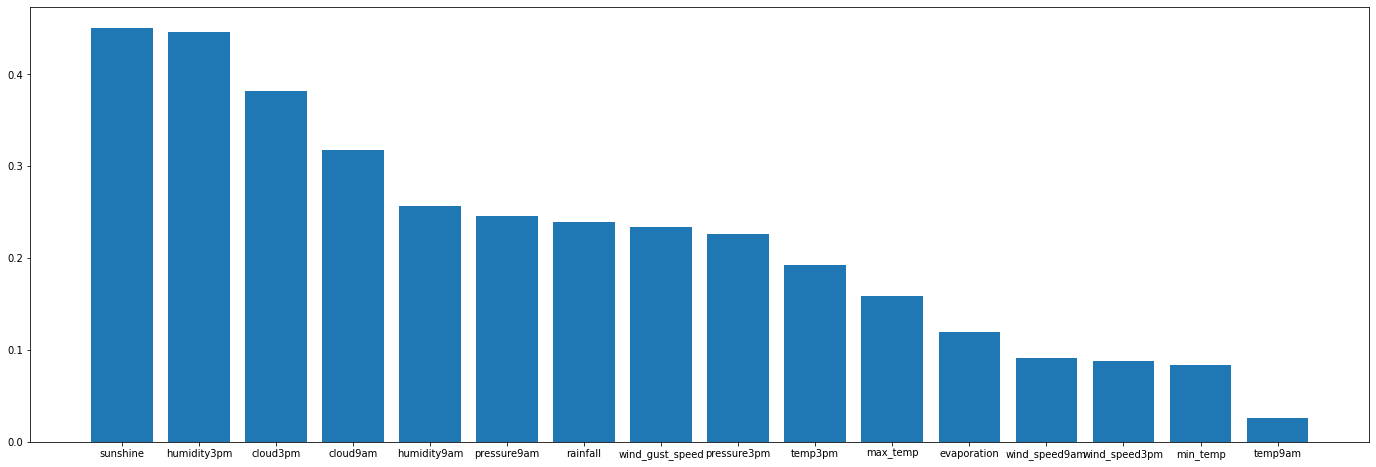

In [20]:
_corr = dataset.corrwith(dataset['rain_tomorrow'].replace({'Yes': 1, 'No': 0})).abs().sort_values(ascending=False)
plt.figure(figsize=(8 * 3, 8))
plt.bar(_corr.index, _corr.values);

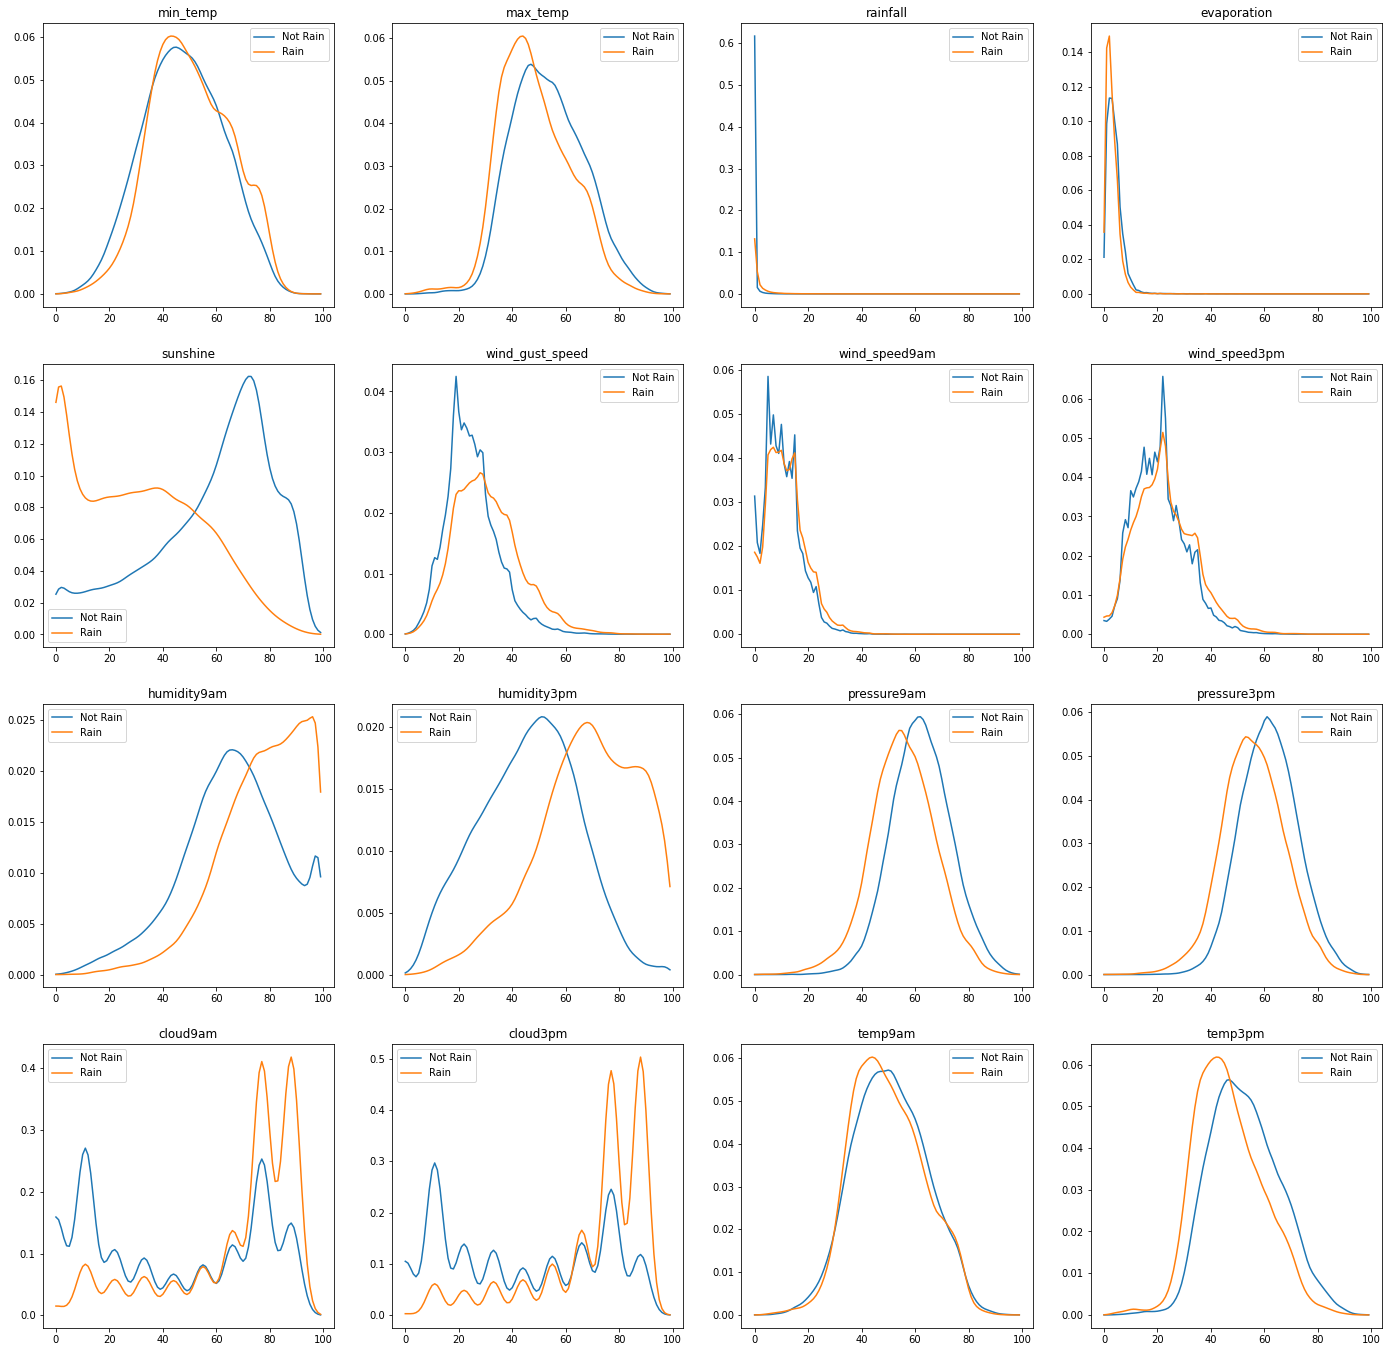

In [21]:
columns = dataset.select_dtypes(include=['number']).columns

n_cols = 4
n_rows = int(np.ceil(len(columns) / n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 24))

for index in range(0, len(columns), n_cols):
    for offset in range(n_cols):
        col = columns[index + offset]
        _dataset = dataset.copy().dropna(subset=[col])

        zero_kde = stats.gaussian_kde(_dataset[_dataset['rain_tomorrow'] == 'No'][col])
        one_kde = stats.gaussian_kde(_dataset[_dataset['rain_tomorrow'] == 'Yes'][col])

        _ax = ax[index // n_cols, offset]

        _ax.plot(zero_kde.evaluate(np.linspace(_dataset[col].min(), _dataset[col].max(), 100)), label='Not Rain')
        _ax.plot(one_kde.evaluate(np.linspace(_dataset[col].min(), _dataset[col].max(), 100)), label='Rain')

        _ax.set_title(col)
        _ax.legend()

        if index + offset >= len(columns):
            break

> **So what we do after visualizing the data?**
> we try to eyeball the data and see which features are important.

> **how do I know which features are important?**
> it is simple, just try to find bimodal distribution in the data.

> **so what is bimodal distribution?**
> it is a distribution that has two peaks. I will try to visualize it

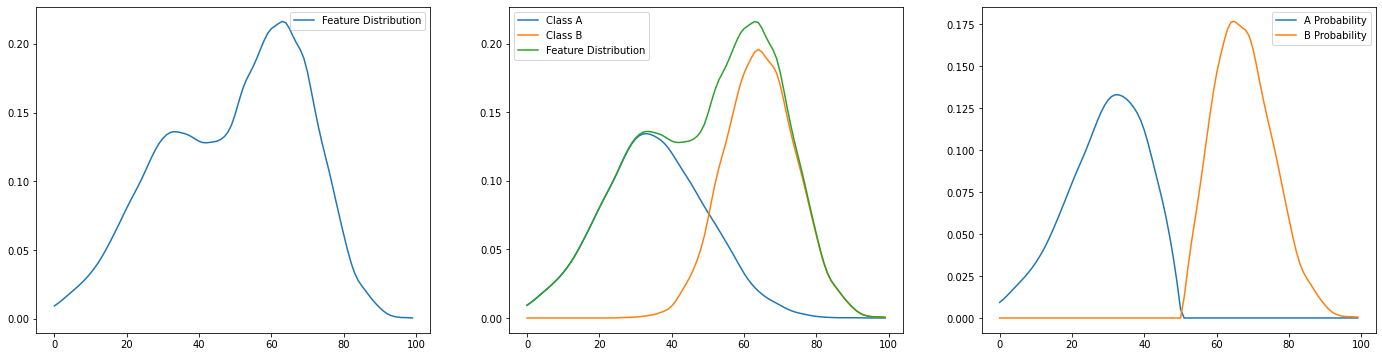

In [22]:
_space = np.linspace(-10, 10, 100)
_a = stats.gaussian_kde(np.random.normal(loc=-3, scale=3, size=10_000)).evaluate(_space)
_b = stats.gaussian_kde(np.random.normal(loc=3, scale=2, size=10_000)).evaluate(_space)

fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 6))

ax[0].plot(_a + _b, label='Feature Distribution')
ax[0].legend()

ax[1].plot(_a, label='Class A')
ax[1].plot(_b, label='Class B')
ax[1].plot(_a + _b, label='Feature Distribution')
ax[1].legend()

ax[2].plot((_a - _b).clip(0, None), label='A Probability')
ax[2].plot((_b - _a).clip(0, None), label='B Probability')
ax[2].legend();

>> After plotting the underlying principle of the data we can start to understand them, let's start from the first one (Left). we have some feature that look not so normal distribution but there are not so called non-normal because we visualize them incorrectly,
>
>> **Why Incorrect?**
> because we try to plot 2 difference distribution into the same line/graph what should we do is the center plot we should differentiate the two distribution, so we can better see how they are created and how they are different, so we can at least give the model a hint about where 2 class are. and from the center image we can try to collapse 2 probability into normalized probability that does not contain another probability.
>
>> **How?**
> it is simple just subtract the probability of the other class. and from the visualisation there are clear defining line where the probability of class A dominate and the probability of class B start. from those we can rest asure so at least the model should be able to distinguish between the two class. just from one feature
>
> **So What is the important feature?**
> to me from those quick analysis we can see the following features are important:
> - **max_temp**
> - **sunshine**
> - ~~**win_gust_speed**~~
> (Ignore This Because we already use it on `Wind Direction` feature)
> - **humidity**
> - **pressure9am**
> - **pressure3pm**
> - **temp9am**
> - **temp3pm**

> **So what happened to the other features?**
> we will try our best to find the best way distinguish between 2 classes.

In [23]:
def _compute_dist(ds, target, n_latent):
    kde = stats.gaussian_kde(ds[target])
    space = np.linspace(ds[target].min(), ds[target].max(), n_latent)
    return space, kde.evaluate(space)


def plot_class_distribution(ds, col, target, ax=plt, n_latent=100):
    _space_neg, _dist_neg = _compute_dist(ds[ds[target] == 'No'], col, n_latent)
    _space_pos, _dist_pos = _compute_dist(ds[ds[target] == 'Yes'], col, n_latent)
    _space = np.linspace(np.minimum(_space_pos[0], _space_neg[0]), np.maximum(_space_pos[-1], _space_neg[-1]), n_latent)

    ax.plot(_space, _dist_neg, label='Not Rain')
    ax.plot(_space, _dist_pos, label='Rain')

    ax.legend()

    return _space, _dist_neg, _dist_pos


def plot_distribution(space, dist_neg, dist_pos, ax=plt):
    neg_prob = np.clip(dist_neg - dist_pos, 0, None)
    pos_prob = np.clip(dist_pos - dist_neg, 0, None)

    ax.plot(space, neg_prob, label='Rain')
    ax.plot(space, pos_prob, label='Not Rain')

    ax.legend()


def plot_probability_dist(ds, col, target='rain_tomorrow', n_latent=100):
    _ds = ds.copy().dropna()

    fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 6))

    _space_neg, _dist_neg = _compute_dist(_ds, col, n_latent)
    ax[0].set_title(f"Distribution of {col}")
    ax[0].plot(_space_neg, _dist_neg)

    ax[1].set_title(f"Rain Distribution in {col}")
    _space_a, _dist_a_neg, _dist_a_pos = plot_class_distribution(_ds, col, target, ax=ax[1], n_latent=n_latent)

    ax[2].set_title(f"Rain Probability in {col}")
    plot_distribution(_space_a, _dist_a_neg, _dist_a_pos, ax=ax[2])


def plot_join_probability_dist(ds, col_a, col_b, transformer, target='rain_tomorrow', n_latent=100):
    _ds = ds.copy().dropna()

    fig, ax = plt.subplots(1, 4, figsize=(8 * 3, 4))

    ax[0].set_title(f"Rain Probability in {col_a}")
    _space_a, _dist_a_neg, _dist_a_pos = plot_class_distribution(_ds, col_a, target, ax=ax[0], n_latent=n_latent)

    ax[1].set_title(f"Rain Probability in {col_b}")
    _space_a, _dist_a_neg, _dist_a_pos = plot_class_distribution(_ds, col_b, target, ax=ax[1], n_latent=n_latent)

    ax[2].set_title(f"Join Probability of Rain in New Feature")
    _ds['diff'] = transformer.transform(_ds[[col_a, col_b]])
    _space_c, _dis_c_neg, _dist_c_pos = plot_class_distribution(_ds, 'diff', target, ax=ax[2], n_latent=n_latent)

    ax[3].set_title(f"Probability Difference in New Feature")
    plot_distribution(_space_c, _dis_c_neg, _dist_c_pos, ax=ax[3])


def column_variance_transformer(df):
    _a, _b = df.columns
    return (df[_b] - df[_a]).values.reshape(-1, 1)


def column_mean_transformer(df):
    _a, _b = df.columns
    return (df[_b] + df[_a] / 2).values.reshape(-1, 1)


variance_extractor = preprocessing.FunctionTransformer(column_variance_transformer)
mean_extractor = preprocessing.FunctionTransformer(column_mean_transformer)

## Feature Engineering
after quick analysis we already know that the important features are, but let's justify not important features and try to make them correlated with the target feature.


> ## Min-Temp and Max-Temp
> **How do I read the graph**
> you need to read it from left to right.

> **What do they mean**
> the left one is the histogram of the feature, then the center is probability distribution from target class to the feature, and the right is the probability distribution from the feature to the target class

> from the right most graph we can justify why the feature is not importance one.
> so from our first example the probability of target is not so well define from the visualisation we can see that there are 2 mountain for each class and that why it is not so good feature to have

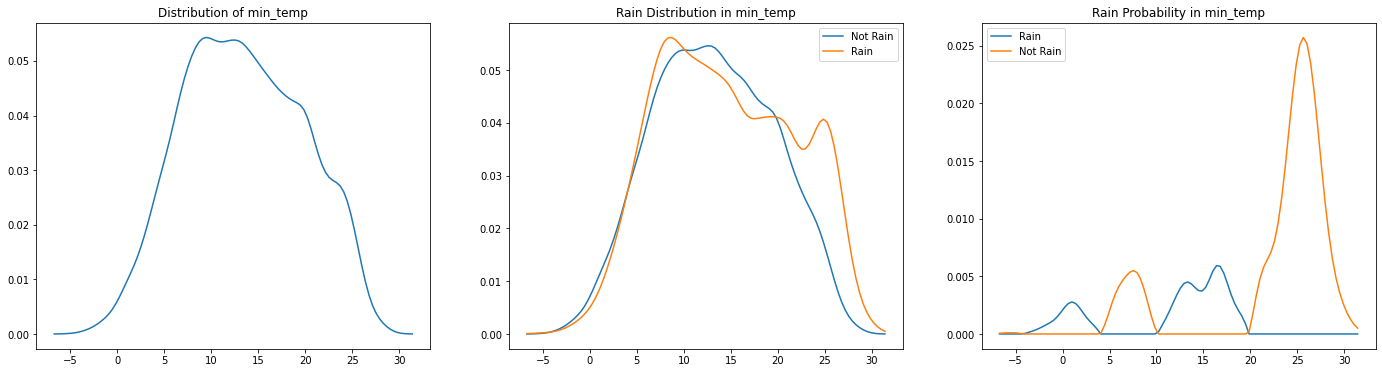

In [24]:
plot_probability_dist(dataset, 'min_temp')

> In the second example the probability is well define but why the feature is not important. but in this case i will use it to generate the new feature by combining 2 feature into one that have more information than 2 individual feature.

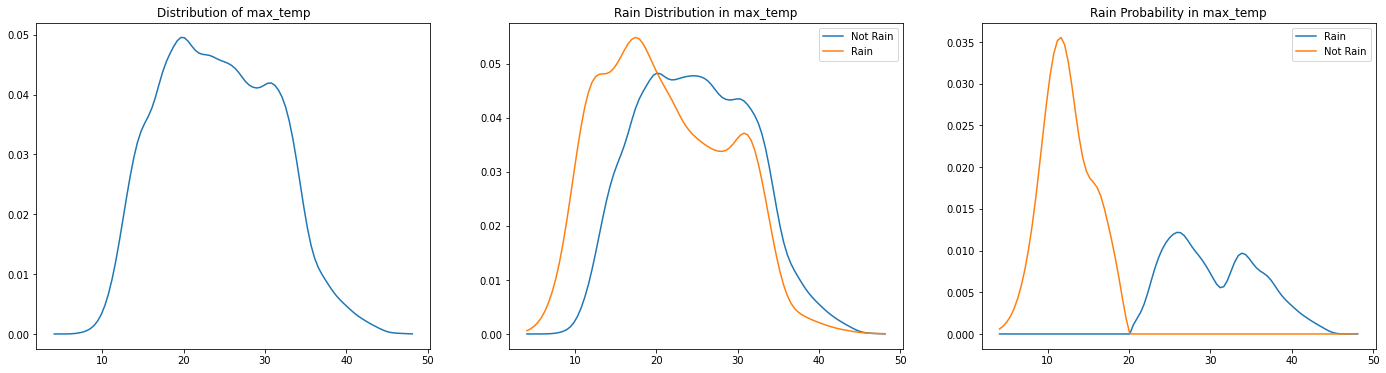

In [25]:
plot_probability_dist(dataset, 'max_temp')

> Let's try to maximize the difference between probability of rain and not rain by combining 2 feature into one. we can start by calculating the difference between the max_temp and min_temp.

> **Why we need to do this**
> because I want to see if the difference between max_temp and min_temp is correlated with the target. or in other word is the aggressive temp spike or calm temp spike. will have any correlation between the target and the feature.

> as we can see that they are correlated and have slightly different probability distribution. but at leas they're only showing 2 peak in the histogram. so we already successfully extracting hidden feature from the 2 data

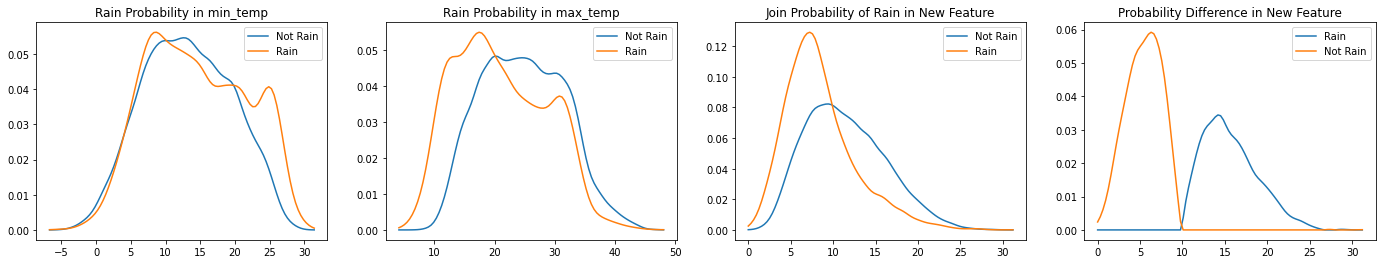

In [26]:
plot_join_probability_dist(dataset, 'min_temp', 'max_temp', variance_extractor)

> ## Pressure3pm and Pressure9am

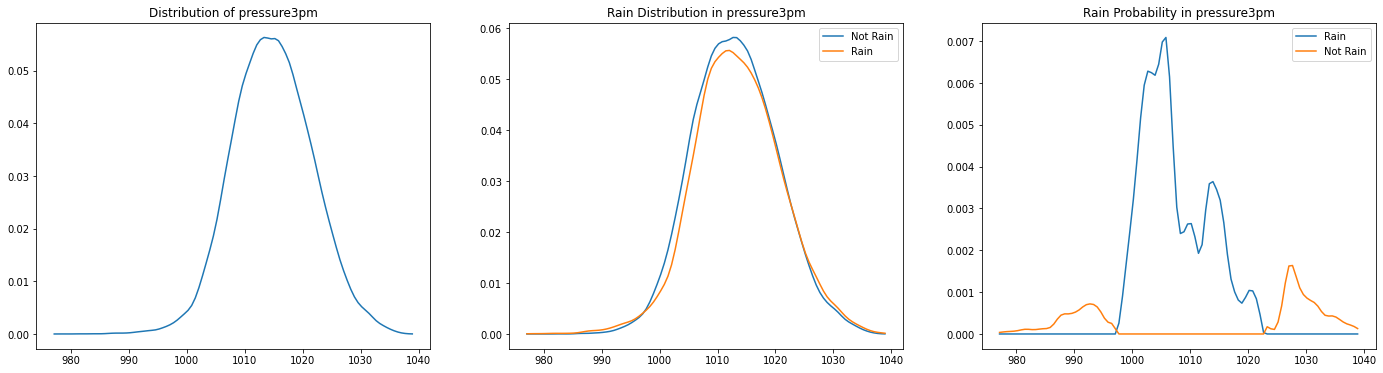

In [27]:
plot_probability_dist(dataset, 'pressure3pm')

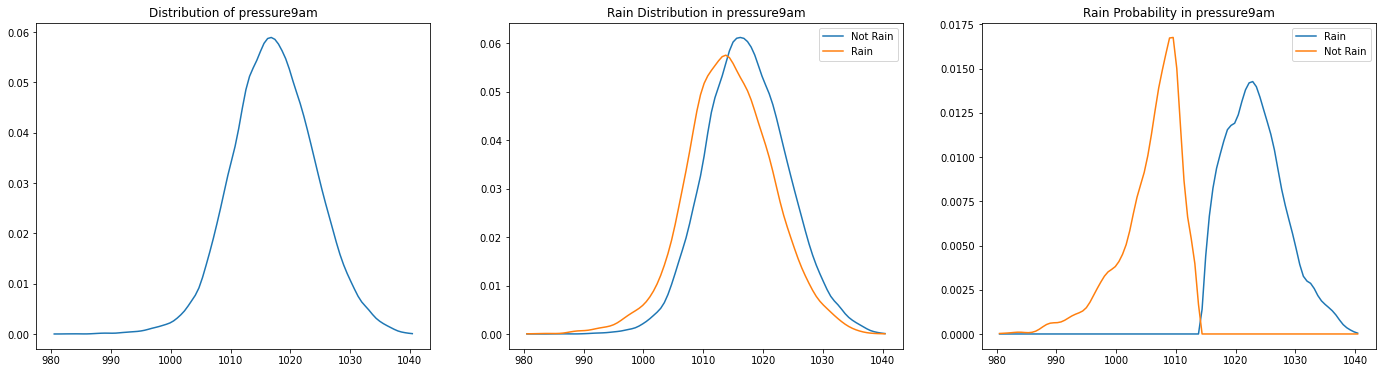

In [28]:
plot_probability_dist(dataset, 'pressure9am')

> same like the previous example, and we successfully extract the hidden feature from the 2 data.

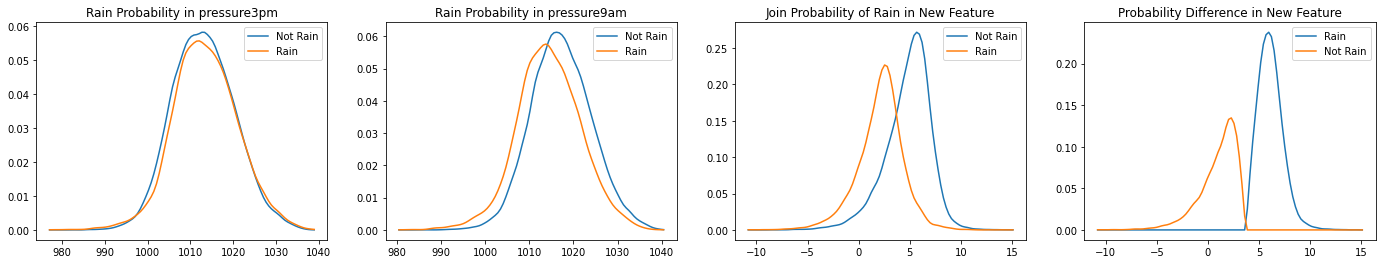

In [29]:
plot_join_probability_dist(dataset, 'pressure3pm', 'pressure9am', variance_extractor)

> ## Cloud3pm and Wind Cloud9am

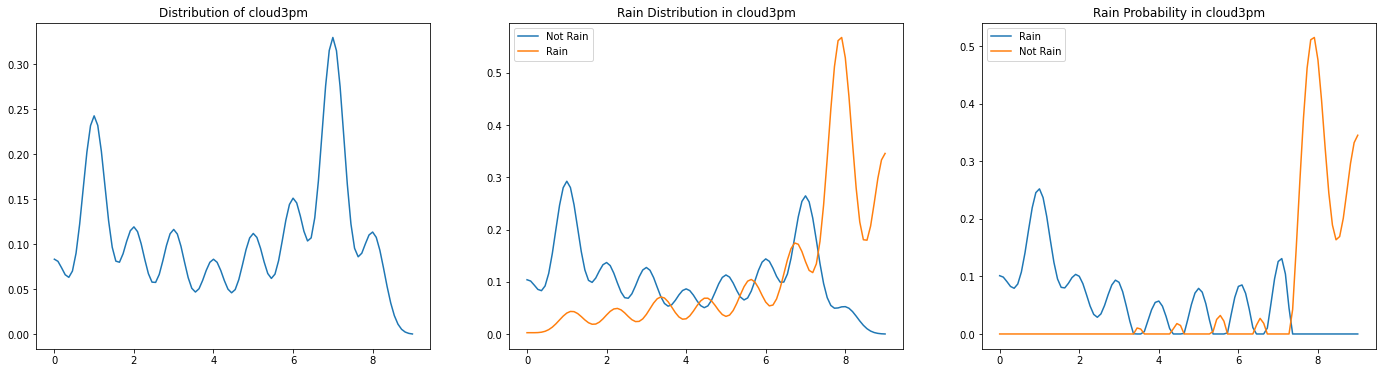

In [30]:
plot_probability_dist(dataset, 'cloud3pm')

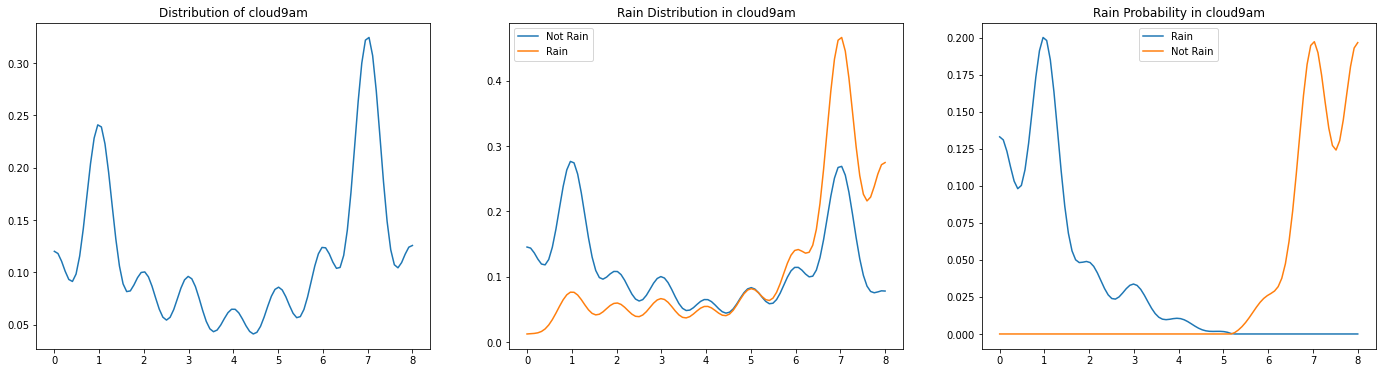

In [31]:
plot_probability_dist(dataset, 'cloud9am')

> same, we successfully extract the hidden feature from the 2 data.
but in this case we see that something is wrong with the data. the 2 feature and the output on `Not Rain` class have 2 peak in the histogram, so we can say that cloud was depending on another feature and not independent

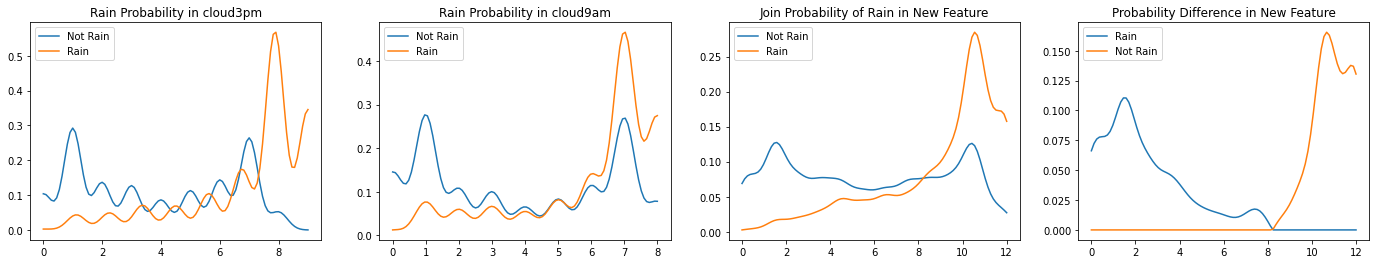

In [32]:
plot_join_probability_dist(dataset, 'cloud3pm', 'cloud9am', mean_extractor)

> ## Temp3pm and Temp9am

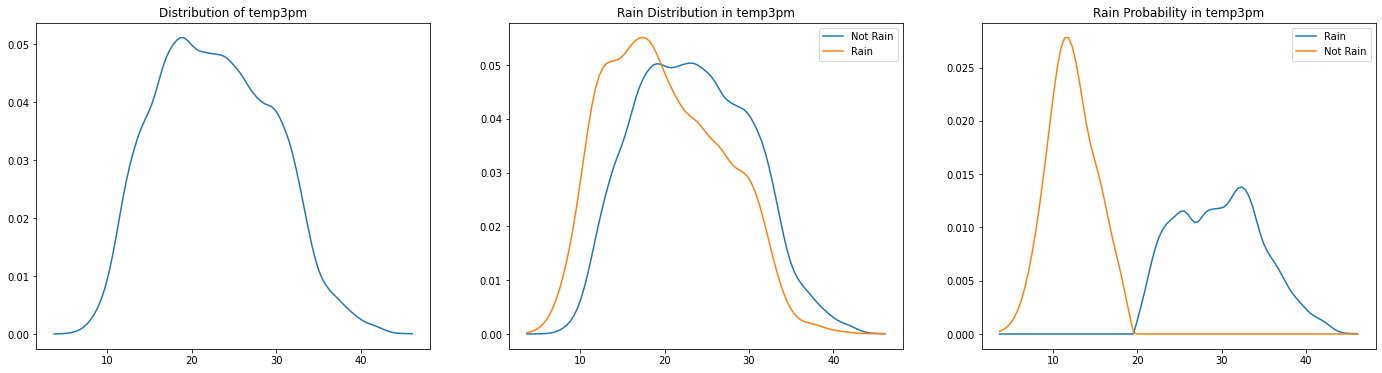

In [33]:
plot_probability_dist(dataset, 'temp3pm')

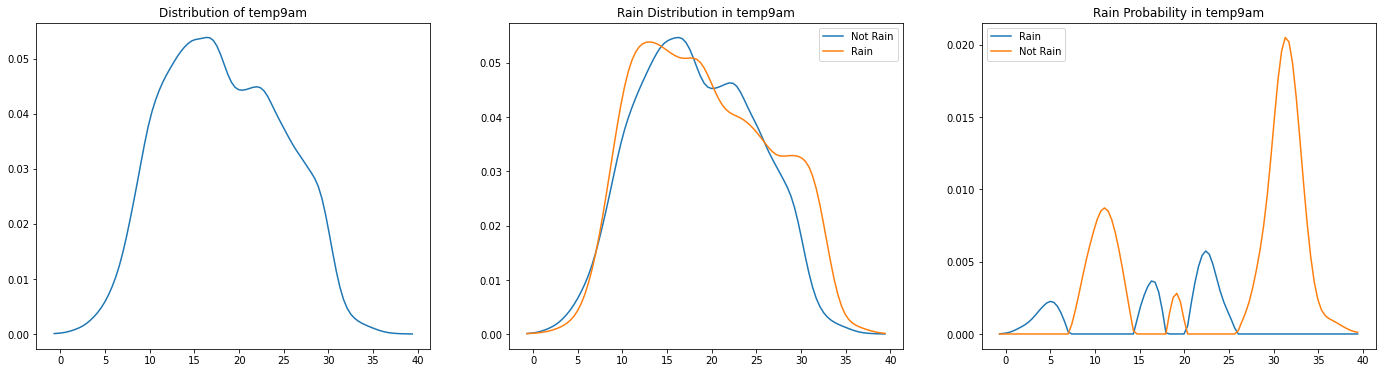

In [34]:
plot_probability_dist(dataset, 'temp9am')

> same too, we successfully extract the hidden feature from the 2 data.

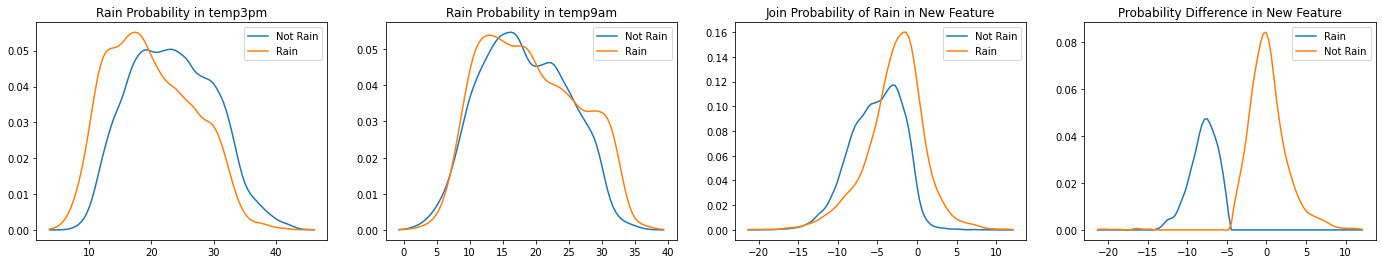

In [35]:
plot_join_probability_dist(dataset, 'temp3pm', 'temp9am', variance_extractor)

# V. Data Preprocessing

> ## Missing Value Handling
> from the information below we can see there are a lot of missing value in the data. and we need to take cyclic/seasonal distribution into account. and imbalance class distribution.

In [36]:
dataset.isna().sum()

date                   0
location               0
min_temp            1485
max_temp            1261
rainfall            3261
evaporation        62790
sunshine           69835
wind_gust_dir      10326
wind_gust_speed    10263
wind_dir9am        10566
wind_dir3pm         4228
wind_speed9am       1767
wind_speed3pm       3062
humidity9am         2654
humidity3pm         4507
pressure9am        15065
pressure3pm        15028
cloud9am           55888
cloud3pm           59358
temp9am             1767
temp3pm             3609
rain_today          3261
rain_tomorrow       3267
dtype: int64

> ## Unlabeled Data
> first we need to split the dataset into 2 kind of data one is labeled and one is unlabeled in this case we only need to resample the sampled data.

In [37]:
missing_index = dataset['rain_tomorrow'].isna()

labeled_dataset = dataset.loc[~missing_index]
unlabeled_dataset = dataset.loc[missing_index]

print(f'Labeled dataset shape: {labeled_dataset.shape}')
print(f'Unlabeled dataset shape: {unlabeled_dataset.shape}')

Labeled dataset shape: (142193, 23)
Unlabeled dataset shape: (3267, 23)


> ## Label Distribution
> as we recall from the dataset explanation there are 2 classes that we need to predict one for positive and one for negative or rain and not rain. from the count there are clear imbalance class distribution. and this will affect the model performance creating the model bias toward majority class. so i do re sampling to balance the class distribution.

In [38]:
x = dataset.copy()

neg = dataset.copy()[x['rain_tomorrow'] == 'No']

n_neg = len(neg)
n_pos = len(x) - n_neg
n_total = n_neg + n_pos

print(f'Negative: {n_neg}, {n_neg / n_total * 100:.2f}%')
print(f'Positive: {n_pos}, {n_pos / n_total * 100:.2f}%')

Negative: 110316, 75.84%
Positive: 35144, 24.16%


> Train, Val and Test Split
> we will split the labeled dataset into 3 major part. train, validation and test.
> one for model training and one for model evaluation.
> and the last part I will use as supervised inference data.

In [39]:
y = x.pop('rain_tomorrow') == 'Yes'
y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=13, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13, stratify=y_train)

print(f'X-Train: {len(x_train)}, X-Val: {len(x_val)}, X-Test: {len(x_test)}')
print(f'Y-Train: {len(y_train)}, Y-Val: {len(y_val)}, Y-Test: {len(y_test)}')

X-Train: 115204, X-Val: 28801, X-Test: 1455
Y-Train: 115204, Y-Val: 28801, Y-Test: 1455


> ## Resampling
> After all necessary step was done.  we can start to resample the minority data. by using this technique we can balance the class distribution although the data just the copy of each other

In [40]:
neg = x_train[y_train == 0]
pos = x_train[y_train == 1].sample(n_neg, replace=True)

x_train = pd.concat([neg, pos])
y_train = np.array([0] * len(neg) + [1] * len(pos))

shuffle_index = np.random.permutation(len(x_train))
x_train = x_train.iloc[shuffle_index]
y_train = y_train[shuffle_index]

n_neg = len(neg)
n_pos = len(pos)
n_total = n_neg + n_pos

print(f'Negative: {n_neg}, {n_neg / n_total * 100:.2f}%')
print(f'Positive: {n_pos}, {n_pos / n_total * 100:.2f}%')

Negative: 89958, 44.92%
Positive: 110316, 55.08%


> ## Weighted Class
> we need to calculate the class weight to balance the estimator output bias. so the model wil not biasing toward slightly towards the majority class.

In [41]:
negative_weight = (1 / n_neg) * (n_total * 2)
positive_weight = (1 / n_pos) * (n_total * 2)

class_weights = {0: negative_weight, 1: positive_weight}
class_weights

{0: 4.4526112185686655, 1: 3.6309148264984232}

> ## Missing Value Handling
> as we state before we have a lot of missing data in the dataset. and to tackle this problem we need to fill the missing value with the mean value of the feature. or we can use alternative by creating another model to predict the missing value we can do this using Iterative Impute.

In [42]:
def plot_dist(df, col, rolling=False, city='Moree', impute=None):
    _df = df.copy()[df['location'] == city]

    fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 4))

    ax[0].hist(_df[_df['rain_tomorrow'] == 'Yes'][col], bins=32, density=True, histtype='step', label='Rain')
    ax[0].hist(_df[_df['rain_tomorrow'] == 'No'][col], bins=32, density=True, histtype='step', label='No Rain')

    _original = _df[col]

    if impute is not None:
        number_df = df.select_dtypes(include=np.number)
        impute.fit(number_df)
        a = impute.transform(_df[number_df.columns])
        _df[col] = pd.DataFrame(a, columns=number_df.columns)[col].values
        ax[1].plot(_df['date'], _df[col].rolling(window=32).mean() if rolling else _df[col], label='Missing Feature')

    ax[1].plot(_df['date'], _original.rolling(window=32).mean(), label='Feature')

    ax[2].hist(_df[_df['rain_tomorrow'] == 'Yes'][col], bins=32, density=True, histtype='step', label='Rain')
    ax[2].hist(_df[_df['rain_tomorrow'] == 'No'][col], bins=32, density=True, histtype='step', label='No Rain')

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

>> ### Iterative Impute
>> Lest check the Iterative Impute performance on the dataset.
>
>> as we can see the iterative impute perform exceptionally well on the dynamic feature like sunshine feature they can follow the cyclic distribution and mimic the original distribution

[IterativeImputer] Completing matrix with shape (145460, 16)
[IterativeImputer] Ending imputation round 1/8, elapsed time 1.06
[IterativeImputer] Change: 152.56547707814465, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 2/8, elapsed time 2.09
[IterativeImputer] Change: 109.71776420194736, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 3/8, elapsed time 3.15
[IterativeImputer] Change: 59.81229013399007, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 4/8, elapsed time 4.19
[IterativeImputer] Change: 30.845044389029464, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 5/8, elapsed time 5.50
[IterativeImputer] Change: 16.946829625821785, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 6/8, elapsed time 6.61
[IterativeImputer] Change: 9.952362762422382, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 7/8, elapsed time 7.79
[IterativeImputer] Change: 6.572504742694194, s

C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


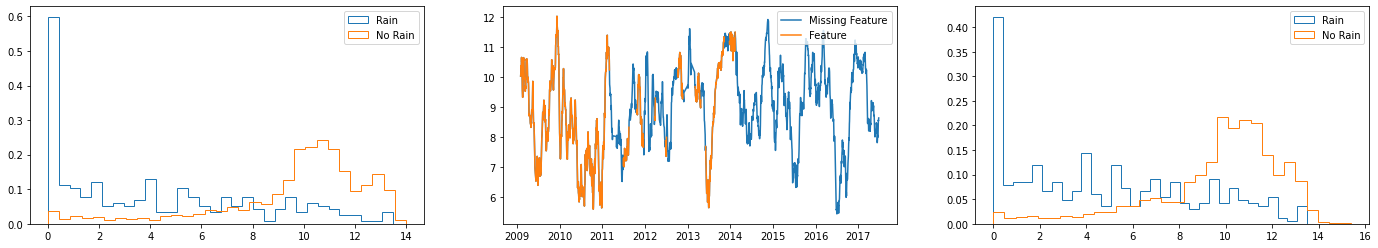

In [43]:
plot_dist(dataset, 'sunshine', rolling=True, impute=IterativeImputer(max_iter=8, random_state=0, verbose=2))

>> ### Mean Impute
>> to better understand the power of iterative impute we will test the same feature but using Mean Imputation and from this example we can see that the impute still perform well but missing the dynamic distribution of the feature and creating anomaly in the distribution because we resample the data only from the mean value of the feature.

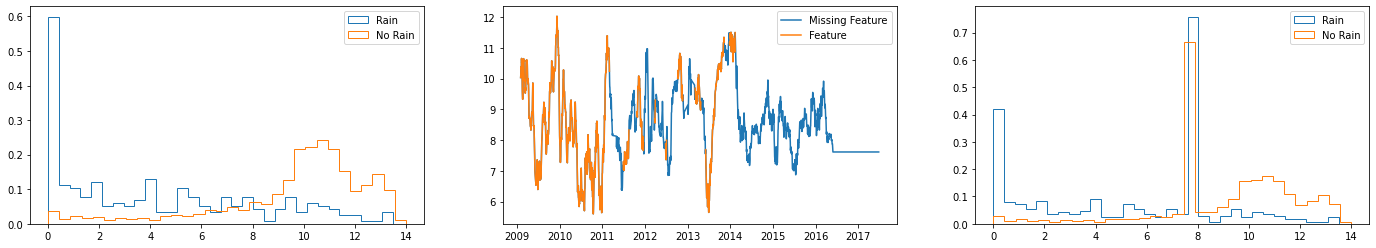

In [44]:
plot_dist(dataset, 'sunshine', rolling=True, impute=SimpleImputer(strategy='mean'))

> ## Outlier Handling
> Alter all EDA and feature engineering i conclude that the dataset is not containing any meaningful outliers and i will not use any outlier handling technique because after seeing the underlying the class distribution in each feature i prefer to use the feature engineering technique to handle the outliers or any weird anomaly. like we see before we try to extract binomial features from the dataset.

> ## Pipelining
> after everything was set up and analyzed we can now start the model training.
> but first we need to define the preprocessing step that we already concluded before.

In [45]:
scaler_pipeline = compose.ColumnTransformer([
    ('year', create_temporal_pipeline('Y'), ['date']),

    ('quarter', create_temporal_pipeline('Q'), ['date']),

    ('wind_gust', make_pipeline(
        WindVectorTransformer(encoder=wind_map),
    ), ['wind_gust_dir', 'wind_gust_speed']),

    ('wind_9am', make_pipeline(
        WindVectorTransformer(encoder=wind_map),
    ), ['wind_dir9am', 'wind_speed9am']),

    ('wind_3pm', make_pipeline(
        WindVectorTransformer(encoder=wind_map),
    ), ['wind_dir3pm', 'wind_speed3pm']),

    ('location', make_pipeline(
        OneHotEncoder(),
    ), ['location']),

    ('rain_today', make_pipeline(
        OrdinalEncoder(),
    ), ['rain_today']),

    ('cloud', make_pipeline(
        mean_extractor,
        StandardScaler(),
    ), ['cloud3pm', 'cloud9am']),

    ('pressure', make_pipeline(
        variance_extractor,
        StandardScaler(),
    ), ['pressure9am', 'pressure3pm']),

    ('temp', make_pipeline(
        variance_extractor,
        StandardScaler(),
    ), ['temp9am', 'temp3pm']),

    ('temp_bound', make_pipeline(
        variance_extractor,
        StandardScaler(),
    ), ['min_temp', 'max_temp']),

    ('numerical', make_pipeline(
        StandardScaler(),
    ), ['humidity9am', 'humidity3pm', 'rainfall', 'evaporation', 'sunshine'])
])

impute_pipeline = SimpleImputer(strategy='mean')

preprocessing_pipeline = pipeline.Pipeline([
    ('scaler', scaler_pipeline),
    ('impute', impute_pipeline),
])

# VI. Model Definition
in this dataset i will use 2 different model to train the data. first one is a Logistic Regression Model and one from SVM Family (SVC). to make this comparison more clear i will use just the default parameter and the same class weight.

**Why Logistic Regression and SVC?**
because problem domain is about classification, and we can use the logistic regression model to solve this problem because our target is a probability and not regression.

**What is The Hyperparameter for the model?**
we will use the default parameter for this model because i think that the default parameter was good enough for this problem.

In [46]:
model_log_reg_pipeline = pipeline.Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LogisticRegression(class_weight=class_weights, random_state=0))
])

model_svm_pipeline = pipeline.Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LinearSVC(class_weight=class_weights, random_state=0))
])

# VII. Model Training
The next important step is to train the model. but remember only train the model using the training set and not the test set or validation set.

In [47]:
model_log_reg_pipeline.fit(x_train, y_train);

In [48]:
model_svm_pipeline.fit(x_train, y_train);

C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


> ## Model Evaluation
> after all training process is done we can start to evaluate our model to see the performance of the model to the training and validation dataset using F1 score and Accuracy score.

In [49]:
def evaluate(model, x, y):
    fig, ax = plt.subplots(1, 2, figsize=(8 * 2, 6))

    ax[0].set_title('AUC ROC Curve')
    ax[1].set_title('Precision-Recall Curve')

    RocCurveDisplay.from_estimator(model, x, y, ax=ax[0])
    PrecisionRecallDisplay.from_estimator(model, x, y, ax=ax[1])
    plt.show()

    _y = model.predict(x)
    print(metrics.classification_report(y, _y))

In [50]:
_y_train = model_log_reg_pipeline.predict(x_train)
_y_val = model_log_reg_pipeline.predict(x_val)

>> ### Logistic Regression
>> From this evaluation this model was performing good enough to the training dataset but there are slight overfited on the traning data on the training dataset.
>
>> **how can i conclude that the model is overwriting?**
>> we can see it from the training and validation evaluation there are significant difference between the training and validation dataset performance more pronounce on the Negative Class (Not Rain)

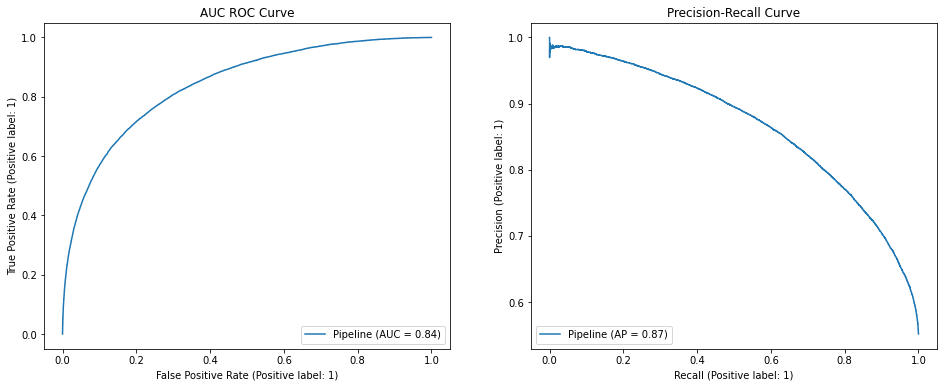

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     89958
           1       0.80      0.75      0.77    110316

    accuracy                           0.76    200274
   macro avg       0.76      0.76      0.76    200274
weighted avg       0.76      0.76      0.76    200274



In [51]:
evaluate(model_log_reg_pipeline, x_train, y_train)

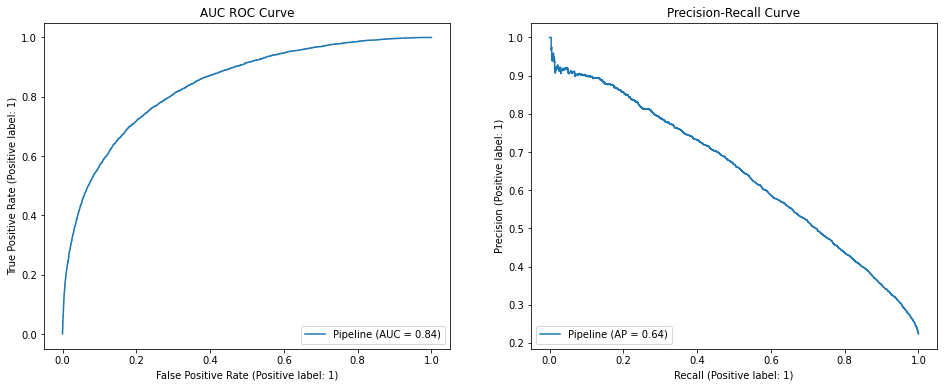

              precision    recall  f1-score   support

           0       0.92      0.77      0.83     22489
           1       0.47      0.75      0.58      6312

    accuracy                           0.76     28801
   macro avg       0.70      0.76      0.71     28801
weighted avg       0.82      0.76      0.78     28801



In [52]:
evaluate(model_log_reg_pipeline, x_val, y_val)

>> ### SVM
>> and the SVM model was perform the same on this dataset. they show good performance on the training dataset but score decreased on the validation dataset. that mean the model was overfitting on the training dataset.

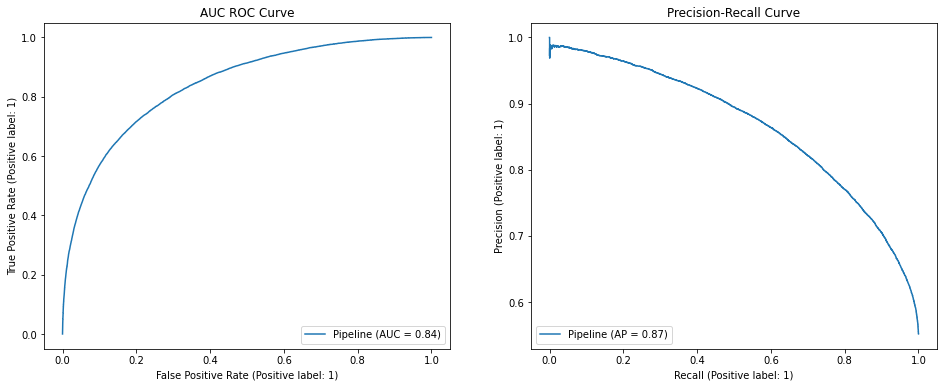

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     89958
           1       0.80      0.74      0.77    110316

    accuracy                           0.76    200274
   macro avg       0.75      0.76      0.76    200274
weighted avg       0.76      0.76      0.76    200274



In [53]:
evaluate(model_svm_pipeline, x_train, y_train)

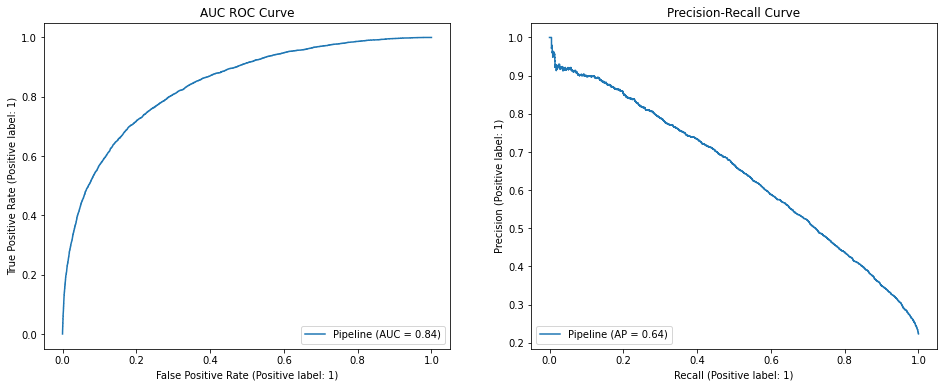

              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22489
           1       0.48      0.75      0.58      6312

    accuracy                           0.76     28801
   macro avg       0.70      0.76      0.71     28801
weighted avg       0.82      0.76      0.78     28801



In [54]:
evaluate(model_svm_pipeline, x_val, y_val)

# VIII. Model Evaluation
So our model is capable to overfit the training dataset that mean the model should be able to learn how to distinguish between the positive class (rain) and the negative class (not rain) but it is not able to do that because some missing information or overlying distribution of the data. and my decision to over sample the minority class (not rain) is making the model slightly overfitted toward the minority class because they are same value.

lest try to optimize our 2 model further to push the boundary of our baseline model

Least's start by optimizing the Logistic Regression Model but in this project i will only try to find the optimum C value.

In [55]:
grid_hyper = {'model__C': [0.1, 1, 10, 100, 1000]}

log_reg_gs = GridSearchCV(model_log_reg_pipeline, grid_hyper, cv=5, scoring='neg_mean_squared_error')
log_reg_gs.fit(x_train, y_train)
log_reg_gs.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'model__C': 1}

In [58]:
grid_hyper = {
    'model__C': [0.1, 10, 1000],
    'model__fit_intercept': [True, False]
}

svm_gs = GridSearchCV(model_svm_pipeline, grid_hyper, cv=5, scoring='neg_mean_squared_error')
svm_gs.fit(x_train, y_train)
svm_gs.best_params_

C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\svm\_

{'model__C': 0.1, 'model__fit_intercept': True}

> After the optimisation there are no significant improvement on the model performance so this mean that our model already on its peak performance in this dataset

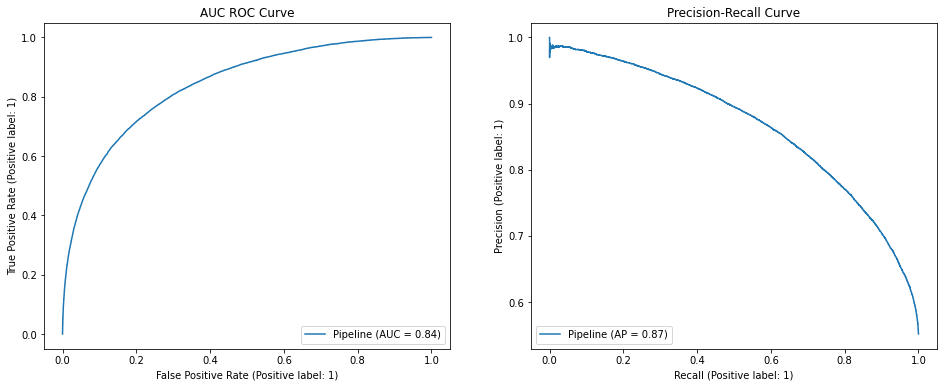

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     89958
           1       0.80      0.75      0.77    110316

    accuracy                           0.76    200274
   macro avg       0.76      0.76      0.76    200274
weighted avg       0.76      0.76      0.76    200274



In [59]:
evaluate(log_reg_gs.best_estimator_, x_train, y_train)

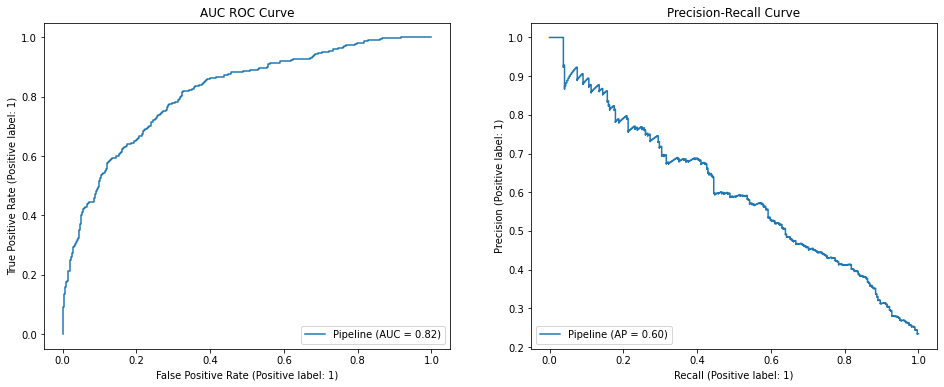

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1136
           1       0.45      0.72      0.55       319

    accuracy                           0.74      1455
   macro avg       0.68      0.74      0.69      1455
weighted avg       0.81      0.74      0.76      1455



In [60]:
evaluate(log_reg_gs.best_estimator_, x_test, y_test)

# IX. Model Inference
> to better see the performance of our model we can use the test set to predict the result and compare them again, so we could validate our model more.
>
> still the same result as before.
> the model was still perform not much better than coin flip on the positive class (rain)

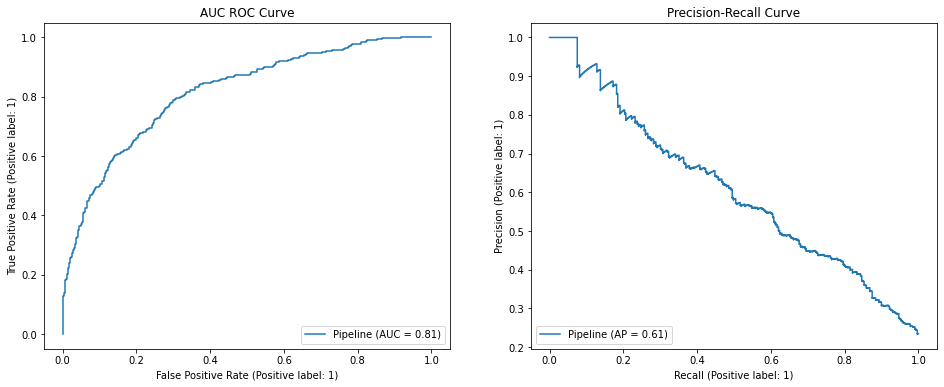

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1136
           1       0.44      0.73      0.55       319

    accuracy                           0.74      1455
   macro avg       0.67      0.73      0.68      1455
weighted avg       0.80      0.74      0.76      1455



In [61]:
evaluate(svm_gs.best_estimator_, x_test, y_test)

In [62]:
_y = svm_gs.best_estimator_.predict(x_test)
pd.DataFrame(np.array([_y, y_test, _y == y_test]).T, columns=['prediction', 'actual', 'match'])

,prediction,actual,match
0,0,0,1
1,0,0,1
2,0,0,1
3,1,1,1
4,1,0,0
...,...,...,...
1450,0,0,1
1451,0,0,1
1452,0,0,1
1453,1,1,1


> we will use Unlabeled data that we split before to predict the outcome of the unlabeled data.

In [63]:
_y = svm_gs.best_estimator_.predict(unlabeled_dataset)
_result = unlabeled_dataset.copy()
_result['prediction'] = ['Rain' if result == 1 else 'Not Rain' for result in _y]
_result

,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir9am,...,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rain_today,rain_tomorrow,prediction
14,2008-12-15,Albury,8.4,24.6,0.0,NaN,NaN,NaN,NaN,S,...,32.0,1009.7,1008.7,NaN,NaN,15.9,23.5,No,NaN,Not Rain
283,2009-09-10,Albury,2.6,NaN,0.0,NaN,NaN,NaN,NaN,E,...,55.0,1017.8,1017.6,NaN,6.0,9.7,14.3,No,NaN,Not Rain
435,2010-02-09,Albury,22.1,35.1,0.0,NaN,NaN,NaN,NaN,ENE,...,37.0,1020.9,1017.8,NaN,1.0,26.9,33.5,No,NaN,Not Rain
437,2010-02-11,Albury,21.5,35.0,0.0,NaN,NaN,NaN,NaN,SSE,...,35.0,1015.8,1010.3,NaN,8.0,24.2,33.1,No,NaN,Not Rain
443,2010-02-17,Albury,15.5,30.6,0.0,NaN,NaN,NaN,NaN,SE,...,30.0,1015.9,1013.8,NaN,NaN,19.4,30.0,No,NaN,Not Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144955,2016-02-07,Uluru,22.5,37.7,0.0,NaN,NaN,SE,50.0,SE,...,11.0,1012.6,1009.6,NaN,NaN,28.8,37.2,No,NaN,Not Rain
145091,2016-06-22,Uluru,12.3,19.1,0.0,NaN,NaN,NaN,NaN,NaN,...,62.0,1016.8,1014.1,8.0,8.0,15.6,18.9,No,NaN,Rain
145092,2016-06-23,Uluru,14.2,18.7,NaN,NaN,NaN,NaN,NaN,W,...,67.0,1015.2,1014.6,8.0,8.0,16.6,17.5,NaN,NaN,Rain
145335,2017-02-21,Uluru,13.5,NaN,0.0,NaN,NaN,NaN,NaN,ENE,...,11.0,1013.7,1008.4,NaN,NaN,25.2,34.4,No,NaN,Not Rain


# X. Analysis
>after all that have we done we can start to analyse the result of our model.
>this dataset contains numerical, temporal, and categorical data that need different steps to be analysed and use.
>then the data contain many missing value that need to be filled in.

>but preprocessing pipeline is the answer to that problem that make us easier to fill in the missing value and transform the data,
>and in the end we still have to fit the dataset into the model and predict the result.

>as we see from the evaluation that Logistic Regressing and SVM model are not perform well on the training dataset either because our method to treat the missing value or imbalance class is not good enough.

# Exploration
>so to further validate my analysis I will train another kind of model that is Multi Layer Perceptron (MLP) if the model perform better than the previous model. so the preprocessing was not the issue but the model itself.

In [64]:
model_mlp_pipeline = pipeline.Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', neural_network.MLPClassifier(
        hidden_layer_sizes=(128, 32),
        batch_size=256,
        random_state=0,
        max_iter=100,
        shuffle=True,
        verbose=2,
    ))
])

model_mlp_pipeline.fit(x_train, y_train);

Iteration 1, loss = 0.45132431
Iteration 2, loss = 0.41371612
Iteration 3, loss = 0.40124890
Iteration 4, loss = 0.39205831
Iteration 5, loss = 0.38423967
Iteration 6, loss = 0.37779845
Iteration 7, loss = 0.37167101
Iteration 8, loss = 0.36572911
Iteration 9, loss = 0.36112921
Iteration 10, loss = 0.35593252
Iteration 11, loss = 0.35148266
Iteration 12, loss = 0.34757394
Iteration 13, loss = 0.34393498
Iteration 14, loss = 0.34007447
Iteration 15, loss = 0.33627887
Iteration 16, loss = 0.33270955
Iteration 17, loss = 0.33047501
Iteration 18, loss = 0.32677537
Iteration 19, loss = 0.32393263
Iteration 20, loss = 0.32086230
Iteration 21, loss = 0.31905093
Iteration 22, loss = 0.31678038
Iteration 23, loss = 0.31390722
Iteration 24, loss = 0.31164055
Iteration 25, loss = 0.30995752
Iteration 26, loss = 0.30757932
Iteration 27, loss = 0.30626315
Iteration 28, loss = 0.30393184
Iteration 29, loss = 0.30305512
Iteration 30, loss = 0.30028383
Iteration 31, loss = 0.29889140
Iteration 32, los

C:\ProgramData\Anaconda3\envs\Hacktiv8\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


> at this point the result was showing promising result but let's see how it performs on the test dataset.

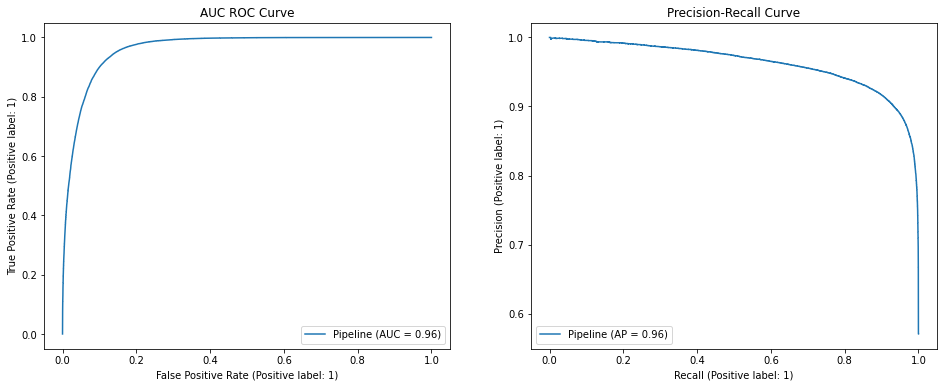

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     89958
           1       0.88      0.96      0.92    110316

    accuracy                           0.91    200274
   macro avg       0.91      0.90      0.90    200274
weighted avg       0.91      0.91      0.91    200274



In [65]:
evaluate(model_mlp_pipeline, x_train, y_train)

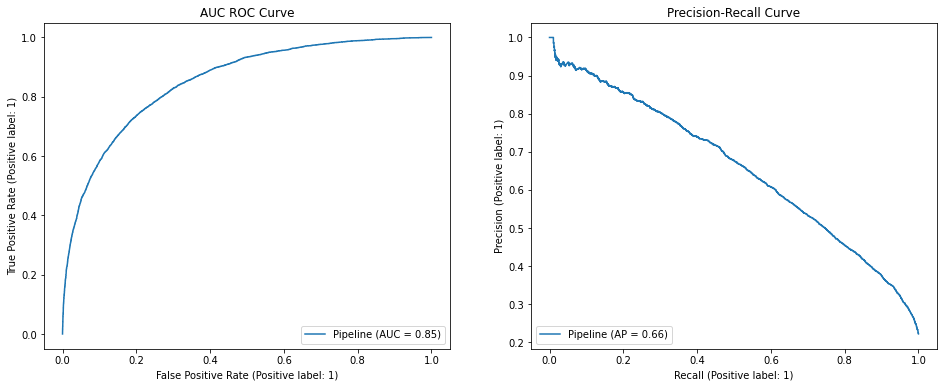

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22489
           1       0.50      0.75      0.60      6312

    accuracy                           0.78     28801
   macro avg       0.71      0.77      0.72     28801
weighted avg       0.83      0.78      0.79     28801



In [66]:
evaluate(model_mlp_pipeline, x_val, y_val)

> ## Conclusion
> The MLP model was still overly fitted to the training dataset even though the model was performing 92% on the training dataset. but still fail to distinguish between the positive class (rain) and the negative class (not rain) in validation dataset, and we can say that either my method of handling missing value or imbalance class is not good enough.
> to further improve the model I propose to use SMOTE to balance the dataset.